# **France data**

Running this notebook does not require a GPU. You can use a frontal node. However, certain parts such as detecting bounding boxes or removing the background from images require GPUs which are launched in external jobs.

In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [11]:
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from PIL import Image
from pathlib import Path

from lynx_id.utils.preprocess.utils import check_filepath, flatten_bbox, get_no_and_multiple_bbox, separate_single_multiple_df, plot_images_conf, absolute_coordinates_bbox
from lynx_id.utils.megadetector.utils import crop_bbox

from idr_pytools import display_slurm_queue, gpu_jobs_submitter, search_log
from megadetector.detection.run_detector_batch import load_and_run_detector_batch, write_results_to_file
from megadetector.utils import path_utils

os.environ['WANDB_DISABLED'] = 'true'  # for megadetector

pd.set_option('display.max_colwidth', None)

In [3]:
# GPU parameters for jobs to be launched (MegaDetector + SAM)
MODULE = 'pytorch-gpu/py3/2.2.0'
account = 'ads@v100'

In [4]:
DATASET = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/")
COUNTRY = "france"
FRANCE_DATASET_PATH = DATASET / COUNTRY / "Deep learning lynx - data" / "0_dataset_raw"
NO_BACKGROUND = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/no_background_new")

---

## **Get images (filepath + lynx_id)**

In [44]:
dataset_dict = {
    "filepath": [],
    "lynx_id": [],
    "source": [],
    "pattern": [],
    "date": [],
    "location": [],
    "image_number": []
}

In [45]:
def parse_filename(filename):
    filename = filename.split(".")[0]
    parts = filename.split("_")
    
    return {"id_lynx": parts[0], "source": parts[1], "pattern": parts[2], "date": parts[3], "location": parts[4], "image_number": parts[5]}

In [46]:
for current_directory, _, files in os.walk(FRANCE_DATASET_PATH):
    if "0_dataset_Marie_3_individus" in current_directory :
        continue

    for file in files:
        absolute_path = os.path.abspath(os.path.join(current_directory, file))
        if file.endswith((".txt", ".xlsx", ".db")):
            continue
        if file.startswith(('broken')):
            print(file)
            continue
        if '.ipynb_checkpoints' in absolute_path:
            print(file)
            continue
            
        try:
            parsed_filename = parse_filename(file)
        except:
            print(absolute_path)  # TODO: problem with these filenames
            continue  # skip them
            
        dataset_dict["filepath"].append(absolute_path)
        dataset_dict["lynx_id"].append(parsed_filename["id_lynx"])
        dataset_dict["source"].append(parsed_filename["source"])
        dataset_dict["pattern"].append(parsed_filename["pattern"])
        dataset_dict["date"].append(parsed_filename["date"])
        dataset_dict["location"].append(parsed_filename["location"])
        dataset_dict["image_number"].append(parsed_filename["image_number"])

broken_FDC01_point_36.2_evosges_le_col_2018_09_01_flanc_droit.JPG
broken_FDC01_point_15.2_corlier_montlier_2019_02_10_flanc_droit_erreur date-F01_047.JPG
broken_1556_FD_2021-05-26-21_100_1-FDC39-Mont-sur-Monnet.jpg
broken_300_2021-05-02-100_1-FDC39-Mont-sur-Monnet.jpg
broken_1556_FD_2021-07-04-21_100_1-FDC39-Mont-sur-Monnet (2).jpg
broken_1556_FG__2021-07-04-21_100_1-FDC39-Mont-sur-Monnet (1).jpg
broken_Villard_F39-038_OFB_OCELLES_2015-03-22_Villard-Saint-Sauveur_4322_03_15.JPG


In [47]:
df_country = pd.DataFrame(dataset_dict)
df_country

,filepath,lynx_id,source,pattern,date,location,image_number
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-04-27,NA,5
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-05-05,NA,1
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-03-17,NA,3
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-03-16,NA,6
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-03-05,NA,7
...,...,...,...,...,...,...,...
3324,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,4
3325,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,3
3326,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,1
3327,/gpfsscratch/rech/ads/commun/datasets/extracte...,1017,OFB,SPOTS,2017-08-08,Chaux-Neuve,2


In [48]:
df_country.nunique()

filepath        3329
lynx_id          272
source             2
pattern            3
date            1123
location         370
image_number     251
dtype: int64

### **Convert date**

**Convert the values in the "date" column into datetime**. The format most often found is YYYY-MM-DD but sometimes day and month are reversed. Some other strange dates are also printed (replaced by NaT).
  
**Note**: NA values are replaced by nan values recognised by pd.isna when the csv is saved.

In [49]:
from datetime import datetime

def convert_date(date_str):
    if pd.isna(date_str):
        return None
    try:
        return datetime.strptime(date_str, "%Y-%m-%d")
    except ValueError:
        try:
            return datetime.strptime(date_str, "%Y-%d-%m")
        except ValueError:
            print(date_str)
            return None
        
df_country["date"] = df_country["date"].apply(convert_date)
df_country

NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
2021
2021
2021-13-13
2021-13-13
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA


,filepath,lynx_id,source,pattern,date,location,image_number
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-04-27,NA,5
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-05-05,NA,1
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-03-17,NA,3
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-03-16,NA,6
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-03-05,NA,7
...,...,...,...,...,...,...,...
3324,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,4
3325,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,3
3326,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,1
3327,/gpfsscratch/rech/ads/commun/datasets/extracte...,1017,OFB,SPOTS,2017-08-08,Chaux-Neuve,2


### **Deleting broken images**

In [50]:
all_files_exist = all(df_country['filepath'].apply(os.path.exists))
all_files_exist

True

## **Bounding box detection**

In [51]:
country_output_megadetector = DATASET / COUNTRY / f"bbox_{COUNTRY}.json"  # WARNING: change filename if needed
country_output_megadetector

In [52]:
image_filenames = df_country['filepath'].tolist()
len(image_filenames)

3329

In [54]:
display_slurm_queue(name=f"megadetector_{COUNTRY}", timestep=60)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            324190   gpu_p13 megadete  uxp55sd  R       7:01      1 r8i6n0

 Done!


In [55]:
with open(country_output_megadetector, 'r') as f:
    bbox_country = json.load(f)

Some images may not have bounding boxes found.

In [56]:
no_bbox_country, multiple_bbox_country = get_no_and_multiple_bbox(bbox_country)

33 images have no bounding boxes detected.
215 images have several bounding boxes detected.
Total: 3329 images.


Absolute coordinates of the bounding box (x, y, width and height) based on the image dimensions

In [57]:
df_bbox_country = flatten_bbox(bbox_country, add_image_without_bbox=False, verbose=False)
df_bbox_country = absolute_coordinates_bbox(df_bbox_country)

df_bbox_country

,file,im_width,im_height,category,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,2592,2000,1,0.938,854.8416,1054.8000,558.8352,289.0000
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,3456,2592,1,0.894,906.8544,948.9312,997.7472,1628.8128
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,2592,2000,1,0.939,1192.8384,821.8000,743.9040,465.8000
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,2592,2000,1,0.965,834.8832,673.8000,594.8640,518.8000
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,1690,1084,1,0.970,765.9080,315.9860,568.8540,392.9500
...,...,...,...,...,...,...,...,...,...
3535,/gpfsscratch/rech/ads/commun/datasets/extracte...,5184,3456,1,0.925,668.7360,1152.9216,3805.5744,2295.8208
3536,/gpfsscratch/rech/ads/commun/datasets/extracte...,5184,3456,1,0.949,1276.8192,880.9344,3906.6624,2475.8784
3537,/gpfsscratch/rech/ads/commun/datasets/extracte...,2623,1749,1,0.902,615.8804,767.9859,1334.8447,828.8511
3538,/gpfsscratch/rech/ads/commun/datasets/extracte...,2576,1984,1,0.959,1797.7904,835.8592,470.8928,251.9680


In [58]:
df_bbox_country.nunique()['file']

3296

### **10 images cropped with the least confidence are displayed**

Only images with a single bounding box are displayed.

In [59]:
df_bbox_country_single_detection, df_bbox_country_multiple_detections = separate_single_multiple_df(df_bbox_country)

print(len(df_bbox_country_single_detection))
print(len(df_bbox_country_multiple_detections))

3081
459


In [60]:
%matplotlib inline

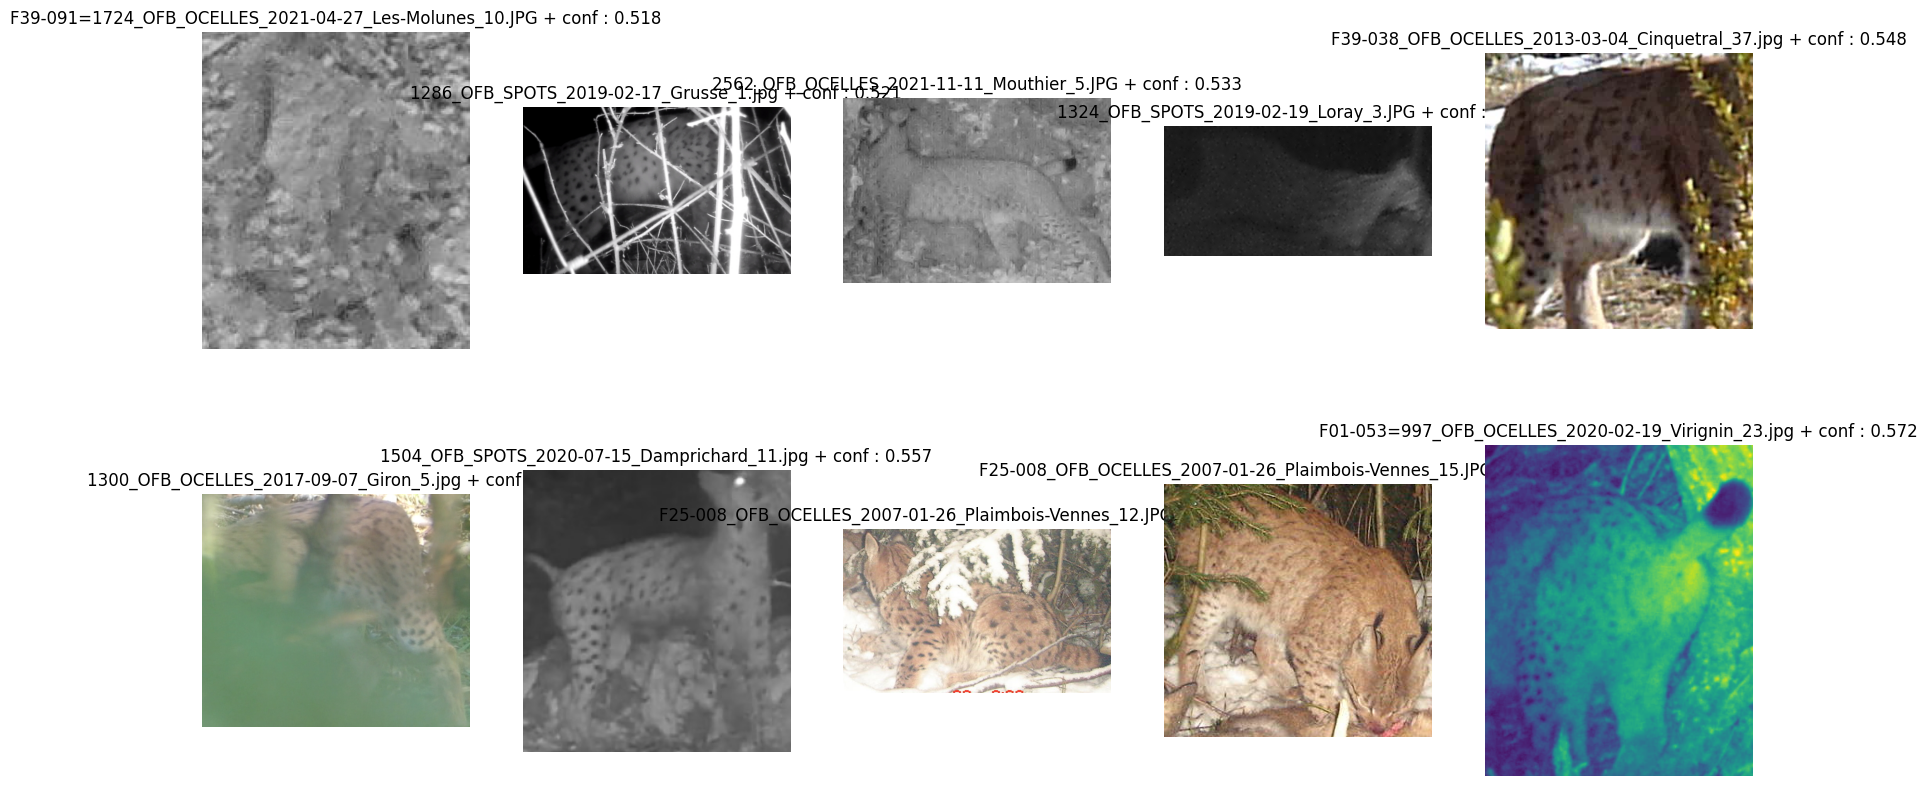

In [61]:
plot_images_conf(df_bbox_country_single_detection, by="smallest")

### **10 images cropped with the largest confidence are displayed**

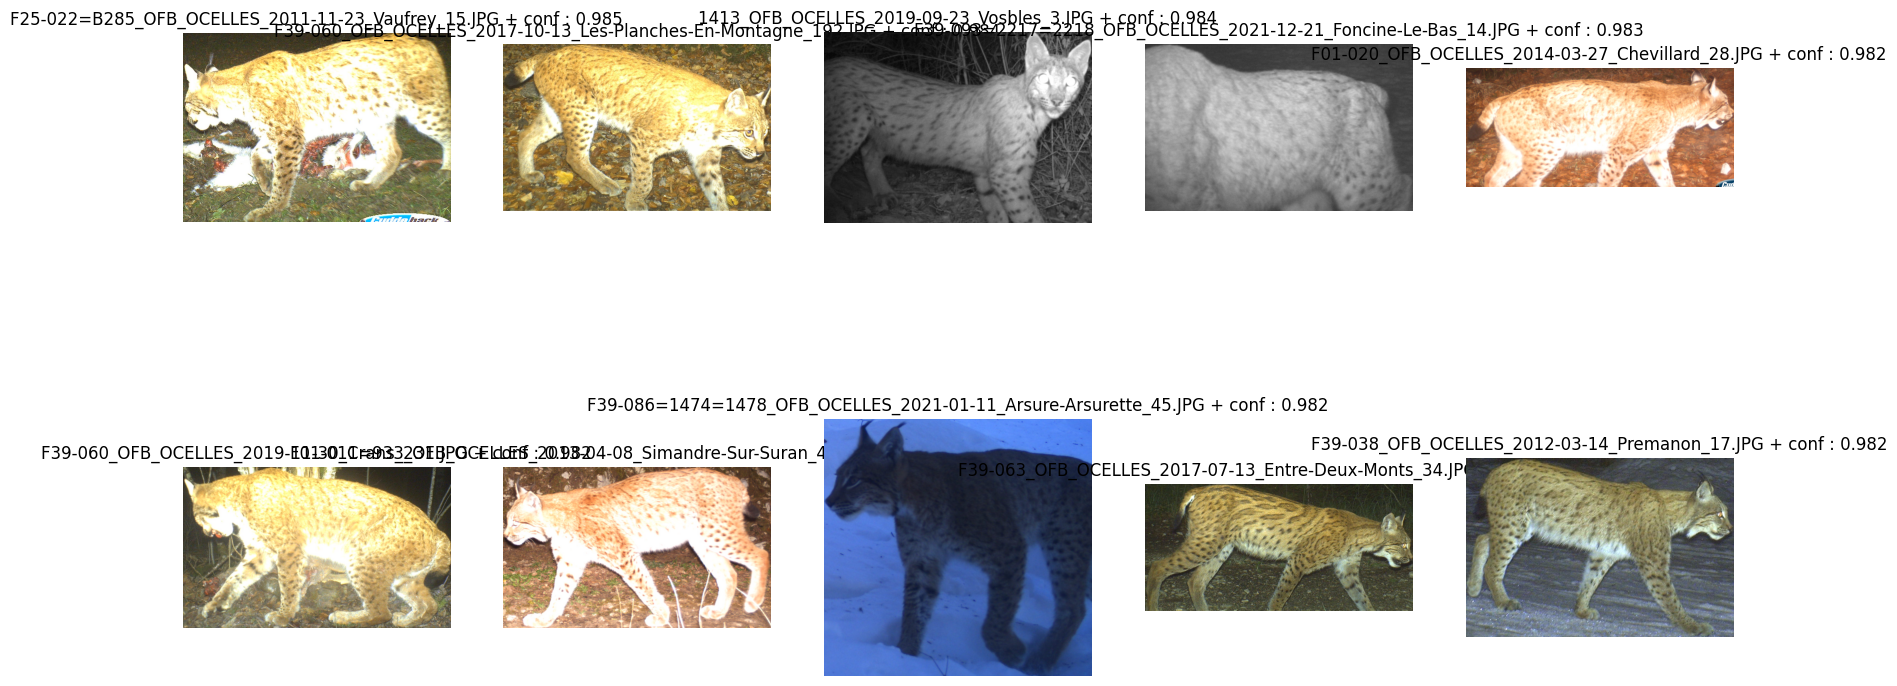

In [62]:
plot_images_conf(df_bbox_country_single_detection, by="largest")

In [63]:
df_country_with_bbox = pd.merge(df_country, df_bbox_country_single_detection[['file', 'conf', 'x', 'y', 'width', 'height']], how='inner', left_on='filepath', right_on='file')
df_country_with_bbox = df_country_with_bbox.drop('file', axis=1)

df_country_with_bbox

,filepath,lynx_id,source,pattern,date,location,image_number,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-04-27,NA,5,0.938,854.8416,1054.8000,558.8352,289.0000
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-05-05,NA,1,0.894,906.8544,948.9312,997.7472,1628.8128
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-03-17,NA,3,0.939,1192.8384,821.8000,743.9040,465.8000
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-03-16,NA,6,0.965,834.8832,673.8000,594.8640,518.8000
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-03-05,NA,7,0.970,765.9080,315.9860,568.8540,392.9500
...,...,...,...,...,...,...,...,...,...,...,...,...
3076,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,4,0.925,668.7360,1152.9216,3805.5744,2295.8208
3077,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,3,0.949,1276.8192,880.9344,3906.6624,2475.8784
3078,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,1,0.902,615.8804,767.9859,1334.8447,828.8511
3079,/gpfsscratch/rech/ads/commun/datasets/extracte...,1017,OFB,SPOTS,2017-08-08,Chaux-Neuve,2,0.959,1797.7904,835.8592,470.8928,251.9680


#### Bounding box confidence distribution

<Axes: xlabel='conf', ylabel='Count'>

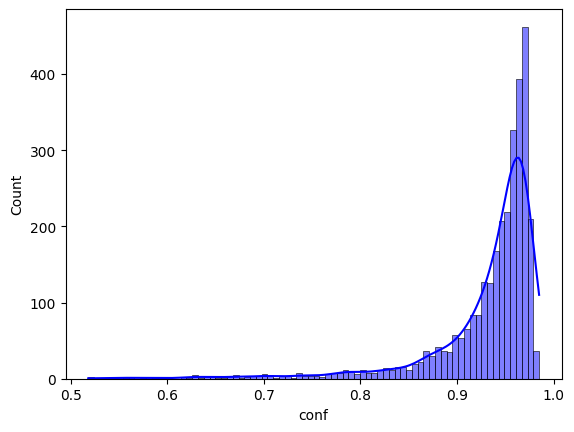

In [64]:
import seaborn as sns

sns.histplot(df_country_with_bbox["conf"], kde=True, color='blue')

## **Compute `image_number` for each individual**

This number is no longer the same as initially following filtering, particularly of images with no bounding box detected, for example.

In [65]:
df_country_with_bbox['image_number'] = df_country_with_bbox.groupby('lynx_id').cumcount() + 1
df_country_with_bbox

,filepath,lynx_id,source,pattern,date,location,image_number,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-04-27,NA,1,0.938,854.8416,1054.8000,558.8352,289.0000
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-05-05,NA,2,0.894,906.8544,948.9312,997.7472,1628.8128
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-03-17,NA,3,0.939,1192.8384,821.8000,743.9040,465.8000
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-03-16,NA,4,0.965,834.8832,673.8000,594.8640,518.8000
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NA,2012-03-05,NA,5,0.970,765.9080,315.9860,568.8540,392.9500
...,...,...,...,...,...,...,...,...,...,...,...,...
3076,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,2,0.925,668.7360,1152.9216,3805.5744,2295.8208
3077,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,3,0.949,1276.8192,880.9344,3906.6624,2475.8784
3078,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,4,0.902,615.8804,767.9859,1334.8447,828.8511
3079,/gpfsscratch/rech/ads/commun/datasets/extracte...,1017,OFB,SPOTS,2017-08-08,Chaux-Neuve,1,0.959,1797.7904,835.8592,470.8928,251.9680


## **Add other information**

In [66]:
df_country_with_bbox['country'] = COUNTRY

In [67]:
df_country_with_bbox.to_csv(DATASET / COUNTRY / f"lynx_dataset_{COUNTRY}.csv", index=False)

## **Remove backgrounds**

Images without backgrounds are calculated using the `Segment Anything Model`. These are saved here: `/gpfsscratch/rech/ads/commun/datasets/extracted/no_background`.  
The csv file is completed with a `filepath_no_bg` column and saved here: `/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full_no_bg.csv`

In [5]:
df_country_with_bbox = pd.read_csv(DATASET / f"{COUNTRY}" / f"lynx_dataset_{COUNTRY}.csv")

### **Add the `filepath_no_bg` column based on existing images**

In [6]:
df_country_with_bbox['filepath_no_bg'] = df_country_with_bbox.apply(lambda row: check_filepath(NO_BACKGROUND, COUNTRY, row['filepath'], row['lynx_id'], row['image_number']), axis=1)

In [7]:
print(f"Number of images remaining to be calculated: {df_country_with_bbox['filepath_no_bg'].isna().sum()}")

Number of images remaining to be calculated: 3081


In [8]:
df_country_with_bbox.to_csv(DATASET / COUNTRY / f"lynx_dataset_{COUNTRY}.csv", index=False)

In [ ]:
display_slurm_queue(name=f'sam_{COUNTRY}', timestep=60)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            350792   gpu_p13 sam_fran  uxp55sd  R      38:02      1 r6i5n1


In [38]:
df_full = pd.read_csv(DATASET / f"{COUNTRY}" / f"lynx_dataset_{COUNTRY}.csv")

In [39]:
df_full.groupby('country').nunique()[['filepath', 'filepath_no_bg']]

,filepath,filepath_no_bg
country,,
France,3081,3081


In [40]:
all_files_exist = df_full['filepath_no_bg'].apply(lambda x: pd.isna(x) or os.path.exists(x)).all()
assert all_files_exist

## **Handle duplicates**

In [41]:
pd.set_option('display.max_colwidth', None)

In [42]:
df_full['basename'] = df_full['filepath'].apply(os.path.basename)
df_full[df_full.duplicated(subset='basename', keep=False)]

,filepath,lynx_id,source,pattern,date,location,image_number,conf,x,y,width,height,country,filepath_no_bg,score_sam,basename


## **Fix lynx_id**

In [36]:
df_full = pd.read_csv(DATASET / f"{COUNTRY}" / f"lynx_dataset_{COUNTRY}.csv")

In [37]:
len(set(df_full.lynx_id.tolist()))

269

In [38]:
df_full['lynx_id'] = df_full['lynx_id'].str.lower()
len(set(df_full.lynx_id.tolist()))

269

In [39]:
df_full['lynx_id'] = df_full['lynx_id'].str.strip()
len(set(df_full.lynx_id.tolist()))

269

In [40]:
mask = df_full['lynx_id'].str.match(r'^[rbl]\d+$')
mask.sum()

0

In [41]:
df_full.loc[mask, 'lynx_id'] = df_full.loc[mask, 'lynx_id'].str[1:]
len(set(df_full.lynx_id.tolist()))

269

In [42]:
print(sorted(set(df_full.lynx_id.tolist())))

['100', '1015', '1017', '1018', '1033=l286', '1044=l261', '1068', '1070', '1079', '1098', '1107', '1115', '1121', '1128', '1131', '1184', '1185', '1208', '1217', '1219', '1224', '1225', '1232', '124', '1246', '1254', '1261', '1265', '1269', '1275', '1276=1278', '1277', '1286', '1292', '1294', '1296=1298', '1300', '1302', '1306', '1308', '1313', '1317', '1320', '1321', '1324', '1342', '1344', '1350=b2011', '1350=b2011-57', '1353=l306', '1370', '1376', '1388', '1397', '1404', '1408', '1413', '1417=oslo', '1436', '1448', '1461', '1479', '1480', '1499', '1502', '1504', '1509', '1512', '1528=b811', '1529', '1537', '1545', '1546=1580=b830', '1548', '1554', '1557', '1561', '1564', '1567', '1569', '1575', '163', '1632', '1704', '1717', '1720', '1722', '1725', '1735', '1756', '1759', '1764', '1765', '1771', '1772', '1780', '1781', '1813', '1864', '1914', '1920', '1921', '1939', '1942', '1947', '1975', '1976', '2001-67-fifo', '2071', '2081', '2101', '2109', '2114', '2125', '2132', '2166', '2208'

In [43]:
df_full.to_csv(DATASET / COUNTRY / f"lynx_dataset_{COUNTRY}.csv", index=False)